In [1]:
import sys
sys.path.append('C:\\Users\\Максимилиан\\Desktop\\Skoltech\\Reinforcement learning\\Final project')
from Dynamics import get_next_state, state_to_coords, get_energy,normalize_angle
from Environment import DoublePendulumEnv, ObservationSpaceCartPole
from PPO.Proximal_Policy_Optimization import PPO, unscaled_action
from PPO.train import train
from PPO.config_PPO import config

In [2]:
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
import gym
from torch.distributions import Normal
from gym.spaces import Box
import random
from IPython.display import clear_output
from torch.distributions import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
state0 = np.array([0,np.pi/2,np.pi/2,
                0,0,0])
state = state0
state
#max_initial_angle = 3 * 2 * np.pi / 360
max_initial_angle = 0
dt = 0.02

In [5]:
oords = np.array(state_to_coords(state)[:, 0])
oords

array([0., 0.])

In [6]:
get_next_state(state,100,10)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


array([ 57.09394275,  -2.53782625,  -2.52245306,  68.56067285,
         3.83151235, -23.02406187])

# Environment

In [7]:
env = DoublePendulumEnv(init_state=state, dt=config['dt'], max_initial_angle = 0)

Environment initialized


C:\Users\Максимилиан\AppData\Roaming\Python\Python38\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


In [8]:
env.action_space.shape[0]

1

In [9]:

def train():
    print("============================================================================================")
    # max. timestep per episode. For DoubleCartPoleEnv, time constraint is 200 timesteps. After that environment is
    # reset.
    max_ep_len = config['max_episode_length']
    # The training phase will sample and update for 1 million timestep.
    max_training_steps = int(config['max_training_steps'])

    # In order, to check ongoing progress, average reward is printed at every 10_000 timesteps.
    print_freq = 10_000

    # Saving model parameters at every 1_00_000 timesteps.
    save_model_freq = int(config['save_model_freq'])

    action_std = config['action_std']  # Initial standard deviation.
    action_std_decay_rate = config['action_std_decay_rate']  # Decay rate of standard deviation.
    min_action_std = config['min_action_std']  # Threshold standard deviation.
    action_std_decay_freq = int(2e5)  # Decay the standard deviation every 200000 timesteps

    update_timestep = config['update_timestep']  # set old_policy parameters to new_policy parameters.
    K_epochs = config['max_number_of_epoch']  # Number of epochs before updating old policy parameters.
    eps_clip = config['eps_clip']  # clip range for surrogate loss function.
    gamma = config['gamma']  # Discount factor.

    lr_actor = config['lr_actor']  # Learning rate for optimizer of actor network.
    lr_critic = config['lr_critic']  # Learning rate for optimizer of critic network.
    env_name = 'DoubleInvPendulum'
    print("Training Environment:" + env_name)
    
    
    
    env = DoublePendulumEnv(init_state=state, dt=config['dt'], max_initial_angle = 0)

    observation_shape = env.observation_space.shape[0]  # Observation shape
    action_shape = env.action_space.shape[0]  # Action shape

    directory = "PPO3_Trained"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = directory + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)


    checkpoint_path = directory + "PPO3_{}.pth".format(env_name)


    print("--------------------------------------------------------------------------------------------")
    print("PPO update frequency : " + str(update_timestep) + " timesteps")
    print("PPO K epochs : ", K_epochs)
    print("PPO epsilon clip : ", eps_clip)
    print("discount factor (gamma) : ", gamma)
    print("--------------------------------------------------------------------------------------------")
    print("optimizer learning rate actor : ", lr_actor)
    print("optimizer learning rate critic : ", lr_critic)

    print("============================================================================================")

    agent = PPO(observation_shape,
                action_shape,
     )


    print("============================================================================================")

    # To keep track of the progress
    print_running_reward = 0
    print_running_episodes = 0

    time_step = 0
    i_episode = 0
    counter = 0

    plot_episode = []
    plot_reward = []

    while time_step <= max_training_steps:
        obs, done = env.reset()
        current_ep_reward = 0
        for t in range(1, max_ep_len + 1):
            
            action = agent.select_action(obs)  # Get action under old_policy given state.
#             if u > 1 or u < -1:
#                 print(u)
            #action = unscaled_action(action)  # Unscale the action.
           
             
            obs, reward, done, _ = env.step(action)  # Apply the action to environment.
    

            # Append the reward and done flag to buffer for calculating Monte Carlo returns during updating phase.
            agent.buffer.rewards.append(reward)
            agent.buffer.dones.append(done)
            
            time_step += 1
            current_ep_reward += reward

            if time_step % update_timestep == 0:
                agent.update()

            if time_step % action_std_decay_freq == 0:
                # Decay standard deviation by 0.1.
                agent.decay_action_std(action_std_decay_rate, min_action_std)

            if time_step % print_freq == 0:
                # print average reward during 10_000 timesteps
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step,
                                                                                        print_avg_reward))

                print_running_reward = 0
                print_running_episodes = 0

            if time_step % save_model_freq == 0:

                # Save the model parameters for test phase and tracking performance.
                print("--------------------------------------------------------------------------------------------")
                print("Saving model at : " + checkpoint_path)
                agent.save(checkpoint_path)
                print("Model saved")
                counter += 1
                inter_checkpoint = directory + "PPO_{}_{}00K.pth".format(env_name, counter)
                print("--------------------------------------------------------------------------------------------")
                print("Model parameters to check for intermediate performance saving:.")
                print("saving model at : " + inter_checkpoint)
                agent.save(inter_checkpoint)
                if counter == 10:
                    print(f"Intermediate model saved for {counter}M")
                else:
                    print(f"Intermediate model saved for {counter}00K")
                print("--------------------------------------------------------------------------------------------")

            if done:
                break

        print_running_reward += current_ep_reward

        # plot reward per 10 episode.
        if i_episode % 10 == 0:
            plot_episode.append(i_episode)
            plot_reward.append(current_ep_reward)

        print_running_episodes += 1

        i_episode += 1

    env.close()

    print("============================================================================================")

    return plot_episode, plot_reward

In [10]:

n_episode, reward_episode = train()

Training Environment:DoubleInvPendulum
Environment initialized
--------------------------------------------------------------------------------------------
PPO update frequency : 2000 timesteps
PPO K epochs :  100
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
--------------------------------------------------------------------------------------------
optimizer learning rate actor :  0.0003
optimizer learning rate critic :  0.001
Episode : 176 		 Timestep : 10000 		 Average Reward : 478.56
Episode : 350 		 Timestep : 20000 		 Average Reward : 488.57
Episode : 523 		 Timestep : 30000 		 Average Reward : 495.69
Episode : 690 		 Timestep : 40000 		 Average Reward : 517.4
Episode : 846 		 Timestep : 50000 		 Average Reward : 571.52
Episode : 990 		 Timestep : 60000 		 Average Reward : 626.89
Episode : 1168 		 Timestep : 70000 		 Average Reward : 475.94
Episode : 1508 		 Timestep : 80000 		 Average Reward : 195.06
Episode : 1775 		 Timestep : 90000 		 Average Reward : 290.31
Episod

Episode : 7451 		 Timestep : 640000 		 Average Reward : 309.85
Episode : 7673 		 Timestep : 650000 		 Average Reward : 281.99
Episode : 7839 		 Timestep : 660000 		 Average Reward : 411.12
Episode : 8128 		 Timestep : 670000 		 Average Reward : 189.31
Episode : 8419 		 Timestep : 680000 		 Average Reward : 177.14
Episode : 8691 		 Timestep : 690000 		 Average Reward : 192.28
Episode : 8943 		 Timestep : 700000 		 Average Reward : 211.58
--------------------------------------------------------------------------------------------
Saving model at : PPO3_Trained/PPO3_DoubleInvPendulum.pth
Model saved
--------------------------------------------------------------------------------------------
Model parameters to check for intermediate performance saving:.
saving model at : PPO3_Trained/PPO_DoubleInvPendulum_700K.pth
Intermediate model saved for 700K
--------------------------------------------------------------------------------------------
Episode : 9172 		 Timestep : 710000 		 Average Rew

In [11]:
%load_ext tensorboard
%tensorboard --logdir = 'PPO_plots'

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

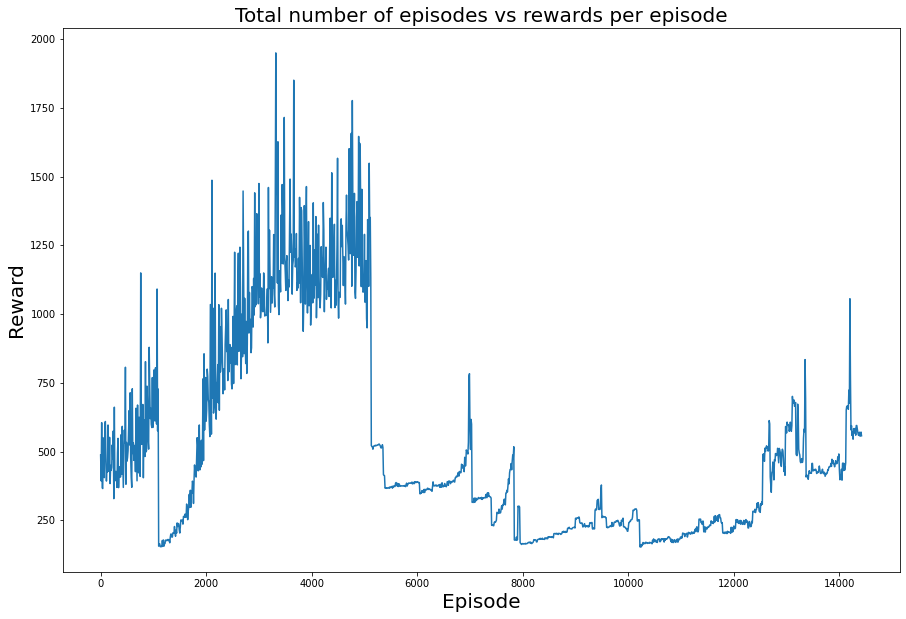

In [12]:
%matplotlib inline
# Plot: Reward per every 10 episodes.
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(n_episode, reward_episode)
ax.set_title('Total number of episodes vs rewards per episode', fontsize=20)
ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Reward', fontsize=20)
plt.show()

NameError: name 'agent' is not defined

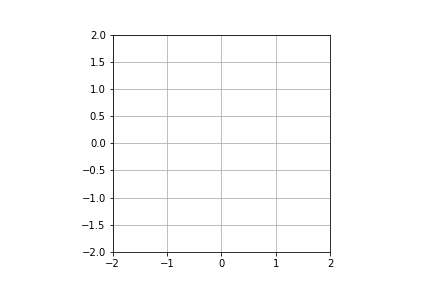

In [13]:
from matplotlib import animation
%matplotlib widget

state = state0

dt = 0.1
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line


def animate(i):
    """perform animation step"""
    global state, dt
    state_t = torch.FloatTensor(state)
    u = agent.select_action(state_t)
    action = unscaled_action(u, action_low = -100, action_high = 100)
    state = get_next_state(state,u,dt)
    XY = state_to_coords(state)
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=100,
                             interval=10, blit=True, init_func=init)

from IPython.display import HTML
HTML(ani.to_jshtml())